In [1]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

from discretize import TensorMesh
from discretize.utils import mkvc, active_from_xyz
from simpeg.utils import plot2Ddata, model_builder
from simpeg import maps
from simpeg.potential_fields import magnetics

write_output = False

import torch

# sphinx_gallery_thumbnail_number = 2

In [2]:
[x_topo, y_topo] = np.meshgrid(np.linspace(-200, 200, 41), np.linspace(-200, 200, 41))
z_topo = -15 * np.exp(-(x_topo**2 + y_topo**2) / 80**2)
x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
xyz_topo = np.c_[x_topo, y_topo, z_topo]

In [3]:
# Define the observation locations as an (N, 3) numpy array or load them.
x = np.linspace(-150.0, 150.0, 30)
y = np.linspace(-150.0, 150.0, 30)
x, y = np.meshgrid(x, y)
x, y = mkvc(x.T), mkvc(y.T)
fun_interp = LinearNDInterpolator(np.c_[x_topo, y_topo], z_topo)
z = fun_interp(np.c_[x, y]) +10  # Flight height 10 m above surface.
receiver_locations = np.c_[x, y, z]

# Define the component(s) of the field we want to simulate as a list of strings.
# Here we simulation total magnetic intensity data.
components = ["tmi"]

# Use the observation locations and components to define the receivers. To
# simulate data, the receivers must be defined as a list.
receiver_list = magnetics.receivers.Point(receiver_locations, components=components)

receiver_list = [receiver_list]

# Define the inducing field H0 = (intensity [nT], inclination [deg], declination [deg])
inclination = 30
declination = 10
strength = 50000

source_field = magnetics.sources.UniformBackgroundField(
    receiver_list=receiver_list,
    amplitude=strength,
    inclination=inclination,
    declination=declination,
)

# Define the survey
survey = magnetics.survey.Survey(source_field)

In [4]:
nx, ny, nz = 30,30,30
dx, dy, dz = 10, 10, 5
cell_volume = dx * dy * dz  # Volume of each cell

hx = [(dx, nx)]
hy = [(dy, ny)]
hz = [(dz, nz)]
mesh = TensorMesh([hx, hy, hz], "CCN")

In [5]:
# Define susceptibility values for each unit in SI
background_susceptibility = 0.0
sphere_susceptibility = 0.01
block_susceptibility = 0.008

# Find cells that are active in the forward modeling (cells below surface)
ind_active = active_from_xyz(mesh, xyz_topo)

# Define mapping from model to active cells
nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)  # model is a vlue for each active cell

model = background_susceptibility * np.ones(ind_active.sum())


# --- Bloque rectangular ---
ind_block = (
    (mesh.cell_centers[ind_active, 0] > -50.0)
    & (mesh.cell_centers[ind_active, 0] < -20.0)
    & (mesh.cell_centers[ind_active, 1] > -15.0)
    & (mesh.cell_centers[ind_active, 1] < 15.0)
    & (mesh.cell_centers[ind_active, 2] < -50.0)
    & (mesh.cell_centers[ind_active, 2] > -70.0)
)

model[ind_block] = block_susceptibility

ind_sphere = model_builder.get_indices_sphere(
    np.r_[35.0, 0.0, -60.0], 14.0, mesh.cell_centers
)
ind_sphere = ind_sphere[ind_active]
model[ind_sphere] = sphere_susceptibility


# Para graficar (inyectar NaN en aire)
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

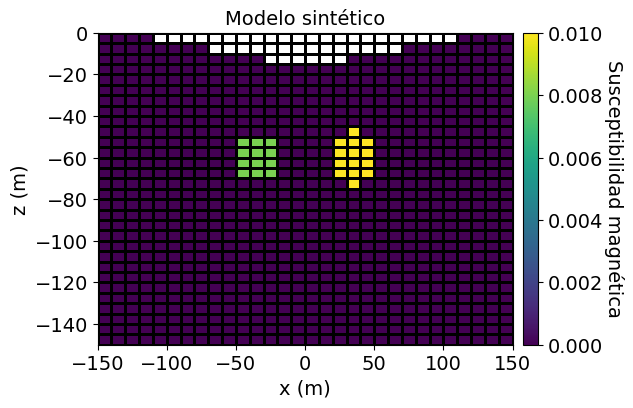

In [6]:
fig = plt.figure(figsize=(5, 4))

ax1 = fig.add_axes([0.1, 0.12, 0.83, 0.78])
mesh.plot_slice(
    plotting_map * model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.shape_cells[1] / 2),
    grid=True,
    clim=(np.min(model), np.max(model)),
)

ax1.set_title("Modelo sintético", size=14)
ax1.set_xlabel("x (m)", size=14)
ax1.set_ylabel("z (m)", size=14)

ax1.tick_params(axis='both', labelsize=14)

ax2 = fig.add_axes([0.95, 0.12, 0.03, 0.78])
norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, orientation="vertical")
cbar.set_label("Susceptibilidad magnética", rotation=270, labelpad=15, size=14)
cbar.ax.tick_params(labelsize=14)
plt.show()